<a href="https://colab.research.google.com/github/Romelianism/Quantum-Resizable-Addition-and-Multiplication/blob/main/Quantum_Resizable_Addition_and_Multiplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit
!pip install pylatexenc

In [2]:
from qiskit import transpile, QuantumCircuit
import qiskit.quantum_info as qi

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel, amplitude_damping_error

from qiskit.tools.visualization import plot_histogram

import numpy as np

In [3]:
# CNOT matrix operator with qubit-0 as control and qubit-1 as target
cx_op = qi.Operator([[1, 0, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]])

# iSWAP matrix operator
iswap_op = qi.Operator([[1, 0, 0, 0],
                        [0, 0, 1j, 0],
                        [0, 1j, 0, 0],
                        [0, 0, 0, 1]])

xor_op = qi.Operator([[1, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 0, 0, 0],
                      [0, 1, 0, 0, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 1]])

or_op = qi.Operator([[1, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 0, 0, 1],
                      [0, 0, 0, 0, 1, 0, 0, 0],
                      [0, 1, 0, 0, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0, 0, 0]])

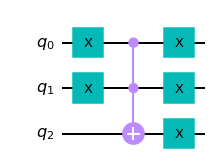

In [4]:
OR_circ = QuantumCircuit(3, name='OR')
OR_circ.x(0)
OR_circ.x(1)
OR_circ.ccx(0,1,2)
OR_circ.x(0)
OR_circ.x(1)
OR_circ.x(2)
OR_circ.draw(output='mpl')

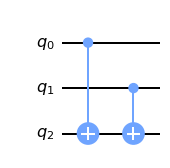

In [5]:
XOR_circ = QuantumCircuit(3, name='XOR')
XOR_circ.cx(0,2)
XOR_circ.cx(1,2)
XOR_circ.draw(output='mpl')

In [6]:
support_unitary = 'unitary' in AerSimulator().configuration().basis_gates
print(support_unitary)
print(AerSimulator().configuration().basis_gates)
assert support_unitary

True
['ccx', 'cp', 'cswap', 'csx', 'cu', 'cu1', 'cu2', 'cu3', 'cx', 'cy', 'cz', 'delay', 'diagonal', 'h', 'id', 'initialize', 'mcp', 'mcphase', 'mcr', 'mcrx', 'mcry', 'mcrz', 'mcswap', 'mcsx', 'mcu', 'mcu1', 'mcu2', 'mcu3', 'mcx', 'mcx_gray', 'mcy', 'mcz', 'multiplexer', 'p', 'pauli', 'r', 'roerror', 'rx', 'rxx', 'ry', 'ryy', 'rz', 'rzx', 'rzz', 's', 'sdg', 'swap', 'sx', 'sxdg', 't', 'tdg', 'u', 'u1', 'u2', 'u3', 'unitary', 'x', 'y', 'z', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'save_amplitudes', 'save_amplitudes_sq', 'save_clifford', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_matrix_product_state', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'save_superop', 'save_unitary', 'set_density_matrix', 'set_matrix_product_state', 'set_stabilizer', 'set_statevector', 'set_superop', 'set_unitary', 'snapshot', 'superop']


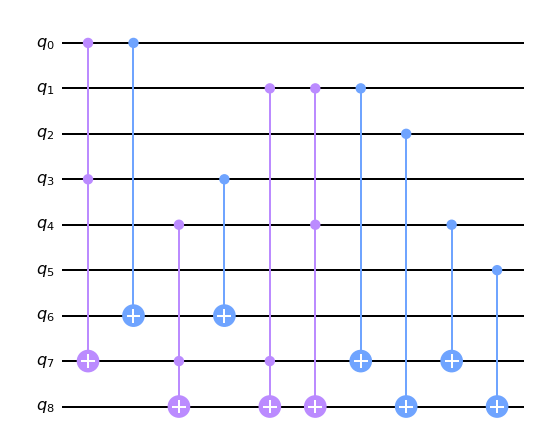

In [7]:
def create_QAddition(input_bit_size, extend_end = False):
  Add_circ = QuantumCircuit(input_bit_size * 3 + extend_end, name='Add')

  if input_bit_size+extend_end > 1:
    Add_circ.ccx(0,input_bit_size, input_bit_size*2+1)

  Add_circ.cx(0, input_bit_size*2)
  Add_circ.cx(input_bit_size, input_bit_size*2)

  for i in range(1,input_bit_size):
    if i < input_bit_size - 1 or extend_end == True:
      Add_circ.ccx(i+input_bit_size, i+input_bit_size*2, i+input_bit_size*2+1)
      Add_circ.ccx(i, i+input_bit_size*2, i+input_bit_size*2+1)
      Add_circ.ccx(i, i+input_bit_size, i+input_bit_size*2+1)
    Add_circ.cx(i, i+input_bit_size*2)
    Add_circ.cx(i+input_bit_size, i+input_bit_size*2)
  return Add_circ

transpile(create_QAddition(3)).draw(output='mpl')

In [8]:
# Quantum Addition Test
q = 4
not_same = []

for b in range(2**q):
  for a in range(2**q):
    # the expected binary string
    a_b = f"{a:b}".rjust(q, '0')
    b_b = f"{b:b}".rjust(q, '0')
    expected_result = f"{a+b:b}".rjust(q, '0')[-q:]
    print(f"expected: {expected_result}={b_b}+{a_b}")

    main_circ = QuantumCircuit(q*3)

    # Set up starting bits
    for i in range(q):
      if a_b[::-1][i] == '1':
        main_circ.x(i)
    for i in range(q):
      if b_b[::-1][i] == '1':
        main_circ.x(i + q)
    main_circ.append(create_QAddition(q), range(q*3))
    main_circ.measure_all()

    # Run simulator
    sim_ideal = AerSimulator()
    binary_string = list(sim_ideal.run(transpile(main_circ, sim_ideal)).result().get_counts(0))[0];
    result = binary_string[:q]
    result_b = binary_string[q:q+q]
    result_a = binary_string[q*2:q*2+q]

    print(f"result  : {result}={result_b}*{result_a}")

    same = result == expected_result and result_b == b_b and result_a == a_b
    print(f"same?: {same}\n")
    if not same:
      not_same.append(f"{result}:{expected_result}={result_b}*{result_a}")
print("List of not same:", not_same)

expected: 0000=0000+0000
result  : 0000=0000*0000
same?: True

expected: 0001=0000+0001
result  : 0001=0000*0001
same?: True

expected: 0010=0000+0010
result  : 0010=0000*0010
same?: True

expected: 0011=0000+0011
result  : 0011=0000*0011
same?: True

expected: 0100=0000+0100
result  : 0100=0000*0100
same?: True

expected: 0101=0000+0101
result  : 0101=0000*0101
same?: True

expected: 0110=0000+0110
result  : 0110=0000*0110
same?: True

expected: 0111=0000+0111
result  : 0111=0000*0111
same?: True

expected: 1000=0000+1000
result  : 1000=0000*1000
same?: True

expected: 1001=0000+1001
result  : 1001=0000*1001
same?: True

expected: 1010=0000+1010
result  : 1010=0000*1010
same?: True

expected: 1011=0000+1011
result  : 1011=0000*1011
same?: True

expected: 1100=0000+1100
result  : 1100=0000*1100
same?: True

expected: 1101=0000+1101
result  : 1101=0000*1101
same?: True

expected: 1110=0000+1110
result  : 1110=0000*1110
same?: True

expected: 1111=0000+1111
result  : 1111=0000*1111
same?

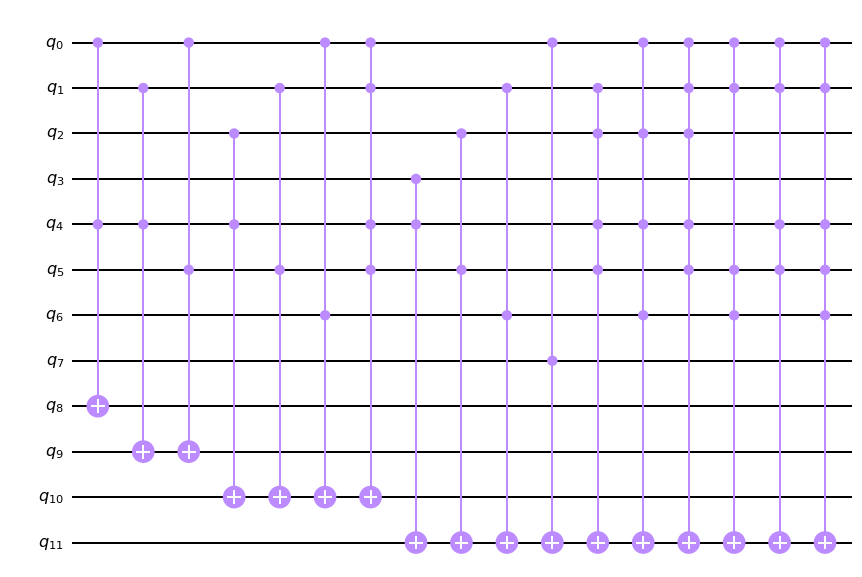

In [9]:
def create_QMultiplication(input_bit_size, double_output = False, enable_carry = True):
  output_size = input_bit_size*2 if double_output else input_bit_size

  #Input1, Input2, Output
  Mul_circ = QuantumCircuit(input_bit_size * 2 + output_size, name='Mul')

  OldMap = []

  for i in range(output_size):

    #Store all the ANDs for calculations (i.e., Can store multi bit AND)
    Map = []

    #No carry multiply (i.e, Just AND)
    h = i+1 - input_bit_size
    h = h if h > 0 else 0
    #print(h)
    for j in range(h, i+1-h):
      Map.append([i-j, j+input_bit_size])

    #Carrys
    #Warning!: Will increase size exponentialy if enabled
    if enable_carry:
      for k in range(len(OldMap)):
        for o in range(1, len(OldMap)-k):
          Map.append([*OldMap[k], *OldMap[k+o]])


    #Applying the ANDs in Map to Output in circuit
    for AND in Map:
      # print(AND)
      Mul_circ.mct(list(set(AND)), i+input_bit_size*2)

    # print(Map)
    OldMap = Map

  return Mul_circ

transpile(create_QMultiplication(4), None, None).draw(output='mpl')

In [10]:
# Quantum Multiplication Test
q = 4
not_same = []

for b in range(2**q):
  for a in range(2**q):
    # the expected binary string
    a_b = f"{a:b}".rjust(q, '0')
    b_b = f"{b:b}".rjust(q, '0')
    expected_result = f"{a*b:b}".rjust(q, '0')[-q:]
    print(f"expected: {expected_result}={b_b}*{a_b}")

    main_circ = QuantumCircuit(q*3)

    for i in range(q):
      if a_b[::-1][i] == '1':
        main_circ.x(i)
    for i in range(q):
      if b_b[::-1][i] == '1':
        main_circ.x(i + q)

    main_circ.append(create_QMultiplication(q), range(q*3))
    main_circ.measure_all()

    sim_ideal = AerSimulator()
    binary_string = list(sim_ideal.run(transpile(main_circ, sim_ideal)).result().get_counts(0))[0];
    result = binary_string[:q]
    result_b = binary_string[q:q+q]
    result_a = binary_string[q*2:q*2+q]

    print(f"result  : {result}={result_b}*{result_a}")

    same = result == expected_result and result_b == b_b and result_a == a_b
    print(f"same?: {same}\n")
    if not same:
      not_same.append(f"{result}:{expected_result}={result_b}*{result_a}")
print("List of not same:", not_same)

expected: 0000=0000*0000
result  : 0000=0000*0000
same?: True

expected: 0000=0000*0001
result  : 0000=0000*0001
same?: True

expected: 0000=0000*0010
result  : 0000=0000*0010
same?: True

expected: 0000=0000*0011
result  : 0000=0000*0011
same?: True

expected: 0000=0000*0100
result  : 0000=0000*0100
same?: True

expected: 0000=0000*0101
result  : 0000=0000*0101
same?: True

expected: 0000=0000*0110
result  : 0000=0000*0110
same?: True

expected: 0000=0000*0111
result  : 0000=0000*0111
same?: True

expected: 0000=0000*1000
result  : 0000=0000*1000
same?: True

expected: 0000=0000*1001
result  : 0000=0000*1001
same?: True

expected: 0000=0000*1010
result  : 0000=0000*1010
same?: True

expected: 0000=0000*1011
result  : 0000=0000*1011
same?: True

expected: 0000=0000*1100
result  : 0000=0000*1100
same?: True

expected: 0000=0000*1101
result  : 0000=0000*1101
same?: True

expected: 0000=0000*1110
result  : 0000=0000*1110
same?: True

expected: 0000=0000*1111
result  : 0000=0000*1111
same?

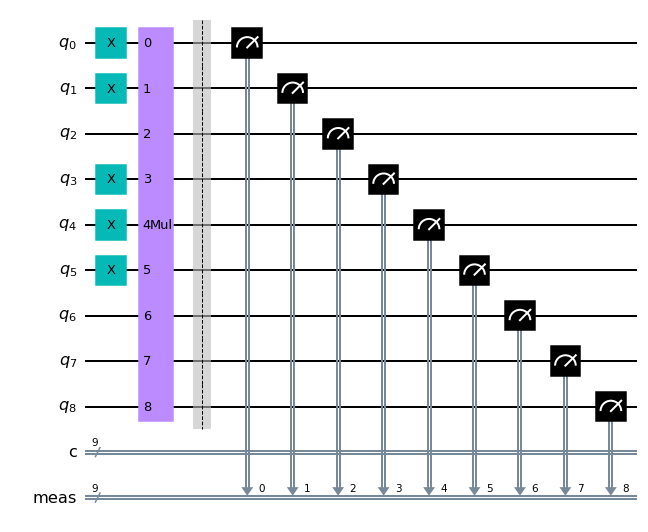

In [12]:
qubits = 9

# Bell state circuit where iSWAPS should be inserted at barrier locations
main_circ = QuantumCircuit(qubits, qubits, name='bell')
main_circ.x(0)
main_circ.x(1)
main_circ.x(3)
main_circ.x(5)
main_circ.x(4)
main_circ.append(create_QMultiplication(int(qubits/3)), range(qubits))

#Measure all
main_circ.measure_all()
main_circ.draw(output='mpl')

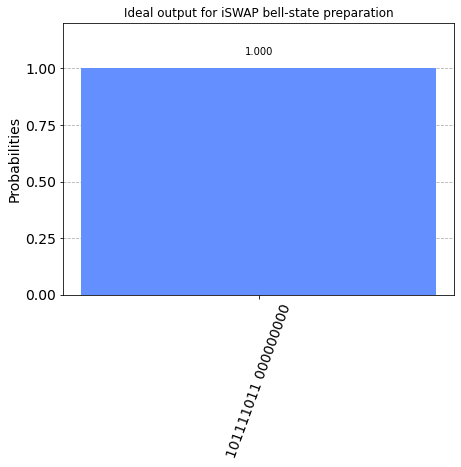

In [13]:
# Create ideal simulator backend and transpile circuit
sim_ideal = AerSimulator()
tmain_circ = transpile(main_circ, sim_ideal)

ideal_result = sim_ideal.run(tmain_circ).result()
ideal_counts = ideal_result.get_counts(0)
plot_histogram(ideal_counts,
               title='Ideal output for iSWAP bell-state preparation')